# Gas2Vec
Author: Michal Stary

This notebook contains adaptation of Spec2Vec for GC-MS data. 

We train the Word2Vec model and evaluate the quality of resulting spectral (document) embeddings. We've implemented several methods to evaluate the embeddings:
1. cluster the resulting spectral embeddings and compare the clusters with chemical classes
2. project the embeddings into the 3D space using dimension reduction techniques and observe manually in Tensorboard
3. compare the similarity scores between emmbeddings pairs obtained from Gas2Vec with the common ground truth obtained by TANIMOTO score on molecular fingerprints.  

## Settings

In [1]:
dataset = "nist"
kind = "in_database"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

%load_ext autoreload
%autoreload 2

## Spectral data
We use the Spec2Vec and MatchMS libraries to load and preprocess spectral data.

Uncomment the pip install lines or run them directly in terminal

In [2]:
from matchms.importing import load_from_msp
from spec2vec import SpectrumDocument
from data_utils import spectrum_processing, get_n_samples
from data_utils import IntegerMzCoder, TextMzCoder, TopKDS, GenDS
import numpy as np

In [3]:
def load_process_documents(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    documents = [SpectrumDocument(s, n_decimals=0) for s in spectrums]
    return documents

documents_train = load_process_documents(data_train_path)

## Gas2Vec model
Load or train the w2v Gensim model using spec2vec library.

Either load pretrained file or uncomment the training and train your own.

In [20]:
# train integer w2v 
from spec2vec.model_building import train_new_word2vec_model

model_unique_file = f"gas2vec/{kind}_over10perc.model"
model_unique = train_new_word2vec_model(documents_train, iterations=list(range(0,101,2)), filename=model_unique_file,
                               workers=32, progress_logger=True, learning_rate_initial=0.01)

The value of learning_rate_initial is set from 0.025 (default) to 0.01
The value of workers is set from 4 (default) to 32
Warning! Number of total iterations is too high for given learning_rate decay.
Learning_rate_decay will be set from 0.00025 to 0.0001.
  Epoch 1 of 100.Change in loss after epoch 1: 183032.390625
  Epoch 2 of 100.Change in loss after epoch 2: 154195.171875
Saving model with name: gas2vec/in_database_over10perc_iter_2.model
  Epoch 3 of 100.Change in loss after epoch 3: 122694.0
  Epoch 4 of 100.Change in loss after epoch 4: 137631.125
Saving model with name: gas2vec/in_database_over10perc_iter_4.model
  Epoch 5 of 100.Change in loss after epoch 5: 144531.0
  Epoch 6 of 100.Change in loss after epoch 6: 133223.125
Saving model with name: gas2vec/in_database_over10perc_iter_6.model
  Epoch 7 of 100.Change in loss after epoch 7: 119685.9375
  Epoch 8 of 100.Change in loss after epoch 8: 145488.75
Saving model with name: gas2vec/in_database_over10perc_iter_8.model
  Epo

In [4]:
# train integer w2v 
from spec2vec.model_building import train_new_word2vec_model

model_unique_file = f"gas2vec/{kind}3.model"
model_unique = train_new_word2vec_model(documents_train, iterations=list(range(0,101,2)), filename=model_unique_file,
                               workers=32, progress_logger=True, learning_rate_initial=0.01)

The value of learning_rate_initial is set from 0.025 (default) to 0.01
The value of workers is set from 4 (default) to 32
Warning! Number of total iterations is too high for given learning_rate decay.
Learning_rate_decay will be set from 0.00025 to 0.0001.
  Epoch 1 of 100.Change in loss after epoch 1: 1300402.75
  Epoch 2 of 100.Change in loss after epoch 2: 1135261.5
Saving model with name: gas2vec/in_database3_iter_2.model
  Epoch 3 of 100.Change in loss after epoch 3: 1117606.5
  Epoch 4 of 100.Change in loss after epoch 4: 1038078.25
Saving model with name: gas2vec/in_database3_iter_4.model
  Epoch 5 of 100.Change in loss after epoch 5: 1059460.0
  Epoch 6 of 100.Change in loss after epoch 6: 1030101.0
Saving model with name: gas2vec/in_database3_iter_6.model
  Epoch 7 of 100.Change in loss after epoch 7: 1072667.5
  Epoch 8 of 100.Change in loss after epoch 8: 1043020.5
Saving model with name: gas2vec/in_database3_iter_8.model
  Epoch 9 of 100.Change in loss after epoch 9: 976422

In [4]:
# train integer w2v 
from spec2vec.model_building import train_new_word2vec_model

model_unique_file = f"gas2vec/{kind}.model"
model_unique = train_new_word2vec_model(documents_train, iterations=list(range(0,103,2)), filename=model_unique_file,
                               workers=32, progress_logger=True, learning_rate_initial=0.01)

The value of learning_rate_initial is set from 0.025 (default) to 0.01
The value of workers is set from 4 (default) to 32
Warning! Number of total iterations is too high for given learning_rate decay.
Learning_rate_decay will be set from 0.00025 to 6.666666666666667e-05.
  Epoch 1 of 150.Change in loss after epoch 1: 1166256.625
  Epoch 2 of 150.Change in loss after epoch 2: 1089180.625
Saving model with name: gas2vec/in_database2_iter_2.model
  Epoch 3 of 150.Change in loss after epoch 3: 1052758.75
  Epoch 4 of 150.Change in loss after epoch 4: 939692.5
Saving model with name: gas2vec/in_database2_iter_4.model
  Epoch 5 of 150.Change in loss after epoch 5: 1139476.0
  Epoch 6 of 150.Change in loss after epoch 6: 946229.0
Saving model with name: gas2vec/in_database2_iter_6.model
  Epoch 7 of 150.Change in loss after epoch 7: 1015146.0
  Epoch 8 of 150.Change in loss after epoch 8: 913748.5
Saving model with name: gas2vec/in_database2_iter_8.model
  Epoch 9 of 150.Change in loss after 

## Evaluation of models' quality
To ensure which version of the model is the best, we compute the Tanimoto structural similarity of coumpounds in validation dataset and observe which checkpoint is most accurately predicting this similarity. 

We use the validation set of all dataset to test this.

In [4]:
# load val dataset
spectrums_val = [spectrum_processing(s) for s in load_from_msp(data_val_path)]
spectrums_val = [s for s in spectrums_val if s is not None]
spectrums_val = get_n_samples(spectrums_val, 5000, 42)

In [6]:
inchis = set()

spectrums_new = []
for s in spectrums_val:
    inchi_pref = s.metadata["inchikey"].split("-")[0]
    if inchi_pref in inchis:
        continue
    inchis.add(inchi_pref)
    spectrums_new.append(s)

In [8]:
len(spectrums_new)

4241

### Tanimoto similariry

In [36]:
#%pip install rdkit-pypi

from matchms import calculate_scores
from matchms import Spectrum
from matchms.filtering import add_fingerprint
from matchms.similarity import FingerprintSimilarity

def add_fingerprints_to_ds(ds):
    specs = [add_fingerprint(rec, nbits=2048) for rec in ds]
    return [s for s in specs if "fingerprint" in s.metadata]
def get_tanimoto_scores(ds):
    similarity_measure = FingerprintSimilarity("jaccard")
#     scores = calculate_scores(ds, ds, similarity_measure)
#     print(np.round(scores.scores, 3))
    return similarity_measure.matrix(ds, ds, is_symmetric=True)



In [46]:
spectrums_new = add_fingerprints_to_ds(spectrums_new)

RDKit ERROR: [18:24:47] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
RDKit ERROR: [18:24:47] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: '[CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'
RDKit WARNING: [18:24:50] WARNING: not removing hydrogen atom without neighbors


In [37]:
import os
tanimoto_matrix_val = get_tanimoto_scores(spectrums_new)
#os.makedirs(f"gas2vec/similarity_{dataset}_val/{kind}", exist_ok=True)
#np.save(f"gas2vec/similarity_{dataset}_val/{kind}/tanimoto_scores", tanimoto_matrix_val)

#tanimoto_matrix_val = np.load(f"gas2vec/similarity_{dataset}_val/{kind}/tanimoto_scores.npy")

RDKit ERROR: [18:17:53] SMILES Parse Error: syntax error while parsing: [CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
RDKit ERROR: [18:17:53] SMILES Parse Error: Failed parsing SMILES '[CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: '[CH-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5|[N-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'
RDKit WARNING: [18:17:55] WARNING: not removing hydrogen atom without neighbors


In [38]:
len(tanimoto_matrix_val[tanimoto_matrix_val != np.nan_to_num(tanimoto_matrix_val)])
#len(tanimoto_matrix_val.ravel())
len(tanimoto_matrix_val[np.isnan(tanimoto_matrix_val)])

0

<AxesSubplot:>

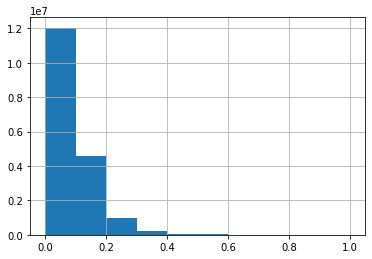

In [42]:
import pandas as pd
pd.Series(tanimoto_matrix_val.ravel()).hist()

### Similarity matrices lookalikeness
we will use  MSE weighted by the tanimoto score to measure the performance of g2v similarity measure. We will add weight 0 to main diagonal.


In [43]:
from sklearn.metrics import mean_squared_error

def tanimoto_weighted_mse(m_ref, m_pred):
    # get weights for mse
    weights = m_ref - np.eye(*m_ref.shape)
    
    return mean_squared_error(m_ref.ravel(), m_pred.ravel(), sample_weight=weights.ravel())

    

### Gas2Vec similarity

In [47]:
#%%capture
import os
from gensim.models import Word2Vec 
from spec2vec import Spec2Vec

#gas2vec_scores = calculate_scores(spectrums, spectrums, spec2vec_similarity)
def get_best_ckpt(folder, model_base_file, spectrums_val, tanimoto_matrix_val):
    min_mse = None
    best_ckpt = None
    ckpt_to_mse = dict()
    ckpt_to_wmse = dict()
    ckpt_to_tmse = dict()
    
    def get_it(x):
        if "iter" not in x:
            return 1000
        return int(x.split(".")[0].split("_")[-1])
    
    for root, dirs, files in os.walk(folder):
        for ckpt in sorted([file for file in files if model_base_file.split(".")[0] in file], key=get_it):
            #print(ckpt)
            #continue
            w2v = Word2Vec.load(f"{folder}/{ckpt}") 
            
            gas2vec_similarity = Spec2Vec(model=w2v, intensity_weighting_power=0.5,
                               allowed_missing_percentage=15.0)
            
            gas2vec_matrix_val = gas2vec_similarity.matrix(spectrums_val, spectrums_val, is_symmetric=True)
            
            #print((gas2vec_matrix_val - tanimoto_matrix_val).mean())
            mse = mean_squared_error(tanimoto_matrix_val.ravel(), gas2vec_matrix_val.ravel())
            weighted_mse = tanimoto_weighted_mse(tanimoto_matrix_val, gas2vec_matrix_val)
            
            
            print(f"{ckpt}: mse: {mse:.3f} wmse:{weighted_mse:.3f}") #, tmse:{perc_mse:.3f}")
            ckpt_to_mse[ckpt] = mse
            ckpt_to_wmse[ckpt] = weighted_mse
           # ckpt_to_tmse[ckpt] = perc_mse
            
            if min_mse is None or weighted_mse < min_mse:
                min_mse = weighted_mse
                best_ckpt = ckpt
                
        return best_ckpt, min_mse, ckpt_to_mse, ckpt_to_wmse#, ckpt_to_tmse
selected = "3"
best_ckpt_unique, min_mse_unique, ckpt_to_mse_unique, ckpt_to_wmse_unique = get_best_ckpt("gas2vec", f"{kind}{selected}.model", spectrums_new, tanimoto_matrix_val)
#best_ckpt_all, min_mse_all, ckpt_to_mse_all, ckpt_to_wmse_all = get_best_ckpt("gas2vec", "all.model", spectrums_val, tanimoto_matrix_val)

in_database3_iter_2.model: mse: 0.020 wmse:0.026
in_database3_iter_4.model: mse: 0.019 wmse:0.027
in_database3_iter_6.model: mse: 0.018 wmse:0.027
in_database3_iter_8.model: mse: 0.018 wmse:0.028
in_database3_iter_10.model: mse: 0.017 wmse:0.027
in_database3_iter_12.model: mse: 0.018 wmse:0.027
in_database3_iter_14.model: mse: 0.018 wmse:0.026
in_database3_iter_16.model: mse: 0.019 wmse:0.027
in_database3_iter_18.model: mse: 0.017 wmse:0.027
in_database3_iter_20.model: mse: 0.017 wmse:0.026
in_database3_iter_22.model: mse: 0.018 wmse:0.027
in_database3_iter_24.model: mse: 0.017 wmse:0.027
in_database3_iter_26.model: mse: 0.017 wmse:0.027
in_database3_iter_28.model: mse: 0.017 wmse:0.027
in_database3_iter_30.model: mse: 0.016 wmse:0.026
in_database3_iter_32.model: mse: 0.017 wmse:0.027
in_database3_iter_34.model: mse: 0.016 wmse:0.027
in_database3_iter_36.model: mse: 0.017 wmse:0.027
in_database3_iter_38.model: mse: 0.017 wmse:0.027
in_database3_iter_40.model: mse: 0.017 wmse:0.027
in_d

In [ ]:
sorted(ckpt_to_mse_unique.items(), key=lambda x: x[1])[:10]

In [ ]:
sorted(ckpt_to_wmse_unique.items(), key=lambda x: x[1])[:10]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# learning curve
def get_epochs(keyval):
    name, val = keyval
    splitted = name.split("_")
    if "iter" not in name:
        return 100
    else:
        return int(splitted[-1].split(".")[0])

def plot_err(dic, ax=None, label=None):
    itms = dic.items()
    mses = [it[1] for it in itms]
    epochs = [*map(get_epochs, itms)]
    return sns.lineplot(x=epochs, y=mses, ax=ax, label=label)

ax = plot_err(ckpt_to_mse_unique, label="mse")
plot_err(ckpt_to_wmse_unique, ax=ax, label="wmse")
#plot_err(ckpt_to_tmse_unique, ax=ax, label= "tmse")
plt.savefig(f"gas2vec/figures/{kind}/{selected}_on_over10.pdf")
ax.set_title("Gas2Vec")


## Load and inspect the best models

In [48]:
#best_ckpt_unique = 'unique_iter_78.model'
# best_ckpt_unique = "in_database_over10perc_iter_16.model"
best_ckpt_unique = "in_database"

In [50]:
# load the models
w2v_unique = Word2Vec.load(f"gas2vec/{best_ckpt_unique}.model")    
#w2v_all = Word2Vec.load(f"gas2vec/{best_ckpt_all}")   

## Evaluating the quality of peaks and spectral embeddings
Now we need to evaluate the peaks/spectral embeddings obtained by Spec2Vec.

Considering our usecases, we need to evaluate both peak (word) embeddings and spectral embeddings. 

** Peak embeddings evaluation**

Possible aproaches:
* Create LM on top of our peak embeddings, observe


**Spectral embeddings evaluation**

Possible aproaches: 
* Qualitaive:
    * Create spectral embeddings and cluster it -> observe

        -> See below

    * Create a spectral embedding and inspect it via tensorboard

        -> See below or online
* Quantitative:
    * Design a similarity task (TANIMOTO )

## Create a spectral embedding 

In [51]:
from spec2vec import Spec2Vec
# Define similarity_function
gas2vec_similarity = Spec2Vec(model=w2v_unique, intensity_weighting_power=0.5,
                               allowed_missing_percentage=15.0)



## Quantitative evaluation 
Evaluation based on comparison of somewhat "structural" TANIMOTO similarity (Jaccard on fingerprints) with Gas2Vec similarity and conventional cosine similarity. Same approach was used in original Spec2Vec paper. (modcos skipped due to its reliance on the precurosor that is available only in MS2)

In [52]:
spectrums_test = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(data_test_path)]
spectrums_test = [s for s in spectrums_test if s is not None]
spectrums_test = get_n_samples(spectrums_test, 5000)
spectrums_test = add_fingerprints_to_ds(spectrums_test)

RDKit WARNING: [18:37:44] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [18:37:49] SMILES Parse Error: syntax error while parsing: OC(=O)[C-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10
RDKit ERROR: [18:37:49] SMILES Parse Error: Failed parsing SMILES 'OC(=O)[C-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10' for input: 'OC(=O)[C-]1|2C|3=C|4C|5=C1|[Fe]6789|2|3|4|5[CH-]%10[CH-]6[CH-]7[CH-]8[CH-]9%10'


In [53]:
inchis = set()

spectrums_new = []
for s in spectrums_test:
    inchi_pref = s.metadata["inchikey"].split("-")[0]
    if inchi_pref in inchis:
        continue
    inchis.add(inchi_pref)
    spectrums_new.append(s)
    
spectrums_test=spectrums_new

### Tanimoto score

In [54]:
tanimoto_matrix = get_tanimoto_scores(spectrums_test)
#tanimoto_matrix = np.load(f"gas2vec/similarity_{dataset}/tani_scores.npy")
#tanimoto_matrix = np.nan_to_num(tanimoto_matrix)

### Modified cosine score 
Moreless conventional similarity on peaks used as a baseline. (see Spec2vec paper for author)

IMPOSSIBLE TO USE BEACUSE OF MISSING PRECURSOR MZ!!

In [55]:
# from matchms.similarity import ModifiedCosine
# # same tolerance as in spec2vec paper
# modcos_similarity = ModifiedCosine(tolerance=0.005)

# modcos_scores = calculate_scores(spectrums, spectrums, modcos_similarity)

### Cosine score 
Conventional similarity on peaks used as a baseline. 

In [56]:
from matchms.similarity import CosineGreedy
def cosine_sim(spectrums_test):
    # same tolerance as in spec2vec paper
    cosine_similarity = CosineGreedy(tolerance=0.005)

    cosine_pairs = cosine_similarity.matrix(spectrums_test, spectrums_test, is_symmetric=True)

    # divide into similarity and matches

    cosine_matrix = np.zeros_like(cosine_pairs, dtype=float)
    cosine_matches = np.zeros_like(cosine_matrix, dtype=int)
    for i in range(cosine_pairs.shape[0]):
        for j in range(cosine_pairs.shape[1]):
            cosine_matrix[i][j] = cosine_pairs[i][j][0]
            cosine_matches[i][j] = cosine_pairs[i][j][1]
            
    return cosine_matrix, cosine_matches
cosine_matrix, cosine_matches = cosine_sim(spectrums_test)
#cosine_matrix = np.load(f"gas2vec/similarity_{dataset}/cos_scores.npy")
#cosine_matches = np.load(f"gas2vec/similarity_{dataset}/cos_matches_scores.npy")

### Weighted cosine score 
Conventional similarity on peaks used as a baseline. 

In [57]:
from matchms.similarity import CosineGreedy
def wcosine_sim(spectrums_test):
    # same tolerance as in spec2vec paper
    cosine_similarity = CosineGreedy(tolerance=0.005, mz_power=1, intensity_power=0.5)

    cosine_pairs = cosine_similarity.matrix(spectrums_test, spectrums_test, is_symmetric=True)

    # divide into similarity and matches

    cosine_matrix = np.zeros_like(cosine_pairs, dtype=float)
    cosine_matches = np.zeros_like(cosine_matrix, dtype=int)
    for i in range(cosine_pairs.shape[0]):
        for j in range(cosine_pairs.shape[1]):
            cosine_matrix[i][j] = cosine_pairs[i][j][0]
            cosine_matches[i][j] = cosine_pairs[i][j][1]
            
    return cosine_matrix, cosine_matches
wcosine_matrix, wcosine_matches = wcosine_sim(spectrums_test)
#cosine_matrix = np.load(f"gas2vec/similarity_{dataset}/cos_scores.npy")
#cosine_matches = np.load(f"gas2vec/similarity_{dataset}/cos_matches_scores.npy")

### Gas2Vec unique score

In [58]:
gas2vec_matrix = gas2vec_similarity.matrix(spectrums_test, spectrums_test, is_symmetric=True)


### Gas2Vec all score

In [59]:
# gas2vec_all_matrix = gas2vec_similarity_all.matrix(spectrums_test, spectrums_test, is_symmetric=True)


### MSE cosine vs gas2vec

In [60]:
mse_g2v = mean_squared_error(gas2vec_matrix, tanimoto_matrix)
# mse_g2v_all = mean_squared_error(gas2vec_all_matrix, tanimoto_matrix)
mse_cos = mean_squared_error(cosine_matrix, tanimoto_matrix)
mse_wcos = mean_squared_error(wcosine_matrix, tanimoto_matrix)

In [61]:
print("Gas2Vec unique MSE: ", mse_g2v)

print("Cosine MSE: ", mse_cos)
print("wCosine MSE: ", mse_wcos)

Gas2Vec unique MSE:  0.014502349165880545
Cosine MSE:  0.015602885567823056
wCosine MSE:  0.018184462867196424


In [62]:
wmse_g2v = tanimoto_weighted_mse(gas2vec_matrix, tanimoto_matrix)
# wmse_g2v_all = tanimoto_weighted_mse(gas2vec_all_matrix, tanimoto_matrix)
wmse_cos = tanimoto_weighted_mse(cosine_matrix, tanimoto_matrix)
wmse_wcos = tanimoto_weighted_mse(wcosine_matrix, tanimoto_matrix)

In [63]:
print("Gas2Vec unique wMSE: ", wmse_g2v)

print("Cosine wMSE: ", wmse_cos)
print("wCosine wMSE: ", wmse_wcos)

Gas2Vec unique wMSE:  0.033499884888931165
Cosine wMSE:  0.057197531412238024
wCosine wMSE:  0.04130904840973338


### Final comparison
Let's avoid reinvetning the wheel and use slightly modified notebooks provided by authors of Spec2Vec for comparison of above computed method. 

We save the similarities in form of numpy file matrices to load them in those notebooks. 

For the final comparison see spec2vec-score_comparison.ipynb and spec2vec-score_comparison2.ipynb.

In [64]:
import os

os.makedirs(f"gas2vec/similarity_{dataset}/{kind}", exist_ok=True)
for score_matrix, scores_name in zip([tanimoto_matrix, gas2vec_matrix, cosine_matrix, cosine_matches, wcosine_matrix, wcosine_matches ],\
                                     ["tani", "g2v", "cos", "cos_match", "wcos", "wcos_match"]):
    
    np.save(f"gas2vec/similarity_{dataset}/{kind}/{scores_name}_scores", score_matrix)



### Summary

In [66]:

spectral_embeddings = np.empty(shape=(len(documents_train), 300))

for i, doc in enumerate(documents_train):
    spectral_embeddings[i] = gas2vec_similarity._calculate_embedding(doc)
    
spectral_embeddings[:10]

array([[ -8.31533608, -15.35433881,  11.86482859, ...,  -9.40319821,
         10.88780595, -20.48422224],
       [-13.47656488, -30.97913685,  34.02184104, ..., -24.501007  ,
          4.99160857,  -2.69695041],
       [-12.0577158 , -24.3758358 ,  26.52782286, ...,  -5.14691938,
        -16.11732789,   9.87090796],
       ...,
       [ 23.50555655, -15.80421665, -32.25177171, ...,  40.52846382,
        -17.05144104, -21.12090656],
       [ 22.18192834, -18.19131026, -29.90715816, ...,  37.89412801,
        -14.16886927, -19.03497246],
       [ 16.7638387 ,  -8.62567836, -31.344379  , ...,  45.90141909,
        -17.05710099, -21.05784576]])

## Cluster spectral embeddings

Now we try to cluster spectral embeddings using DBSCAN algorithm (due to automatic n_clusters formation)

We visualize the result using PCA and TSNE (eventually tsne visualisation skipped - computing takes too long) 

Note that the vectors were first normalized between 0-1 and euclidean distance was then used. As the crucial eps hyperparameter 0.8 was choosed after few trials, but the results are far from good. 

DBSCAN


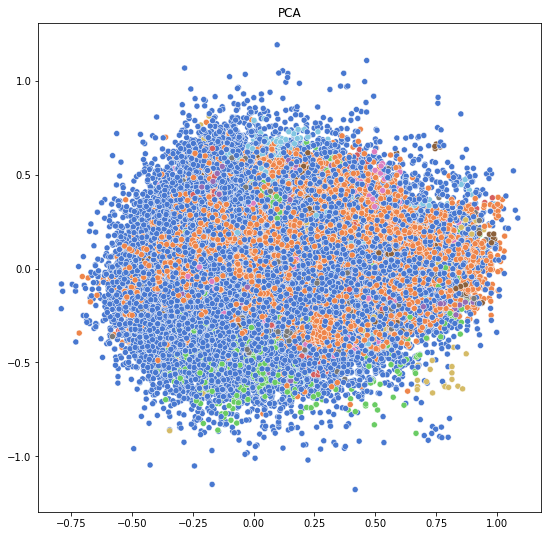

In [71]:
# (PCA, TSNE )+ (KMEANS, DBSCAN)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca_pipeline = make_pipeline(MinMaxScaler(),PCA(n_components=2))
tsne_pipeline = make_pipeline(MinMaxScaler(),TSNE(n_components=2, n_jobs=-1, metric="cosine"))
 

def tsne(features):
    X_reduced = tsne_pipeline.fit_transform(features)
    return X_reduced

def pca(features):
    X_reduced = pca_pipeline.fit_transform(features)
    return X_reduced

def reduce(features, hue = None):
    res_pca = pca(features)
    #res_tsne = tsne(features)
    
    fig, ax = plt.subplots(1,1, figsize=(9,9))
    plot2D(ax, res_pca, "PCA", hue)
    #plot2D(ax[1], res_tsne, "TSNE", hue)
    plt.show()


def plot2D(ax, X_transformed, title, hue):
    cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    g = sns.scatterplot(x=X_transformed[:,0], y=X_transformed[:,1],
                         hue=hue, palette="muted", ax=ax)
    g.legend_.remove()
    
    ax.title.set_text(title)

k_pipeline = make_pipeline( MinMaxScaler(),KMeans( n_clusters=8, n_jobs=-1))
d_pipeline = make_pipeline(MinMaxScaler(),DBSCAN(eps=0.8, min_samples=5, metric="euclidean", n_jobs=-1))


def kmeans(features, show=False):
    labels = k_pipeline.fit_predict(features)
    if show:
        print("KMEANS")
        print()
        reduce(features, labels)
    return labels

def dbscan(features, show=False):
    labels = d_pipeline.fit_predict(features)
    if show:
        print("DBSCAN")
        reduce(features, labels)
    return labels

labels = dbscan(spectral_embeddings, show=True)

In [72]:
pd.Series(labels).value_counts()

-1      132688
 0       92464
 101       549
 68        193
 104       159
         ...  
 540         3
 793         3
 842         3
 365         3
 471         3
Length: 895, dtype: int64

### Clustering observation
Formed clusters are no good at PCA projection. To evaluate them properly we woudl either need to get domain expert (chemist) to go through them manually or to design an anotated dataset or to get spectral similarity dataset. 

## Save embeddings+clusters in tsv format (to use tf online projector)

We will save the current embeddings to make them available online via link in the online tensorborad embedding projector. 

Link to integer precision embeddings on the MoNA dataset with Classyfire classes:

~~https://projector.tensorflow.org/?config=https%3A%2F%2Fgist.githubusercontent.com%2Fmichal-stary%2Fae0484c6e159888471b6d7d31b31516a%2Fraw%2Fd2468d14597b11fed972572c9ec40aa3f3d1673d%2Fgistfile1.txt~~


https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/michal-stary/0d6ee3b3455a27f8a744b5f6b5fbaed1/raw/56bc6adc98dfc6d68f5f9c27e4df6731df95c420/config_mona

In [73]:
# save spectral embeddings to tsv file
np.savetxt('gas2vec/embeddings_indb.tsv', spectral_embeddings, delimiter='\t', fmt='%.6f')

In [75]:
# save metadata with clusters
with open(os.path.join("gas2vec", 'metadata_indb.tsv'), "w") as f:
    f.write(f"name\tcluster\tclass\n")
    for i, doc in enumerate(documents_train):
        if 'classyfire_superclass' not in doc.metadata:
            f.write(f"{doc.metadata['name']}\t{labels[i]}\tnan\n")
        else:
            f.write(f"{doc.metadata['name']}\t{labels[i]}\t{doc.metadata['classyfire_superclass']}\n")


## Inspect embeddings + clusters via tensorboard

For a more dynamic approach, we can use the embedding projector directly in here.

In [81]:
import tensorflow as tf
from tensorboard.plugins import projector
def setup_projector(name, docs, embeddings, labels):
    # Set up a logs directory, so Tensorboard knows where to look for files
    log_dir=f'gas2vec/tf/logs/{name}'
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    # Save Labels separately on a line-by-line manner.
    with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
        f.write(f"name\tcluster\tclass\n")
        for i, doc in enumerate(docs):
            if 'classyfire_superclass' not in doc.metadata:
                f.write(f"{doc.metadata['name']}\t{labels[i]}\tnan\n")
            else:
                f.write(f"{doc.metadata['name']}\t{labels[i]}\t{doc.metadata['classyfire_superclass']}\n")

    # Save the weights we want to analyse as a variable. Note that the first
    # value represents any unknown word, which is not in the metadata, so
    # we will remove that value.
    weights = tf.Variable(embeddings)
    # Create a checkpoint from embedding, the filename and key are
    # name of the tensor.
    checkpoint = tf.train.Checkpoint(embedding=weights)
    checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

    # Set up config
    config = projector.ProjectorConfig()
    embedding = config.embeddings.add()
    # The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
    embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
    embedding.metadata_path = 'metadata.tsv'
    projector.visualize_embeddings(log_dir, config)

In [82]:
setup_projector("spect_indb", documents_train, spectral_embeddings, labels)


In [87]:
%load_ext tensorboard
host = "kirke20.meta.zcu.cz" #"localhost"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [88]:
%tensorboard --logdir gas2vec/tf/logs/spect_indb --host=$host --port=8385
#!python -m tensorboard.main --logdir gas2vec/tf/logs/spect_em --port=6006